In [1]:
# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

import time
import matplotlib.pyplot as plt

In [3]:
from data_helpers.wine_quality_data_helper import load_wine_quality_data
from data_helpers.mnist_data_helper import load_mnist_data

In [4]:
class GaussianMixtureWrapper:
    NAME = 'GMM'
    def __init__(self, n_components):
        self.n_components = n_components
        self.model = GaussianMixture(n_components=n_components)

    def fit(self, X):
        self.model.fit(X)

    def predict(self, X):
        return self.model.predict(X)
    
    def bic(self, X):
        return self.model.bic(X)

    def aic(self, X):
        return self.model.aic(X)

class KMeansWrapper:
    NAME = 'KMeans'
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
        self.model = KMeans(n_clusters=n_clusters)

    def fit(self, X):
        self.model.fit(X)

    def predict(self, X):
        return self.model.predict(X)
    
    def inertia(self):
        return self.model.inertia_

In [5]:
# DATASET_NAME = 'mnist'
DATASET_NAME = 'wine_quality'

METHOD = GaussianMixtureWrapper
# METHOD = KMeansWrapper
SAVE = True

if DATASET_NAME == 'mnist':
    num_components = 2
elif DATASET_NAME == 'wine_quality':
    num_components = 5

In [6]:
if DATASET_NAME == 'wine_quality':
    DATASET_STR = 'Wine Quality'
    X, y, _, _ = load_wine_quality_data()
elif DATASET_NAME == 'mnist':
    DATASET_STR = 'MNIST'
    X, y, _, _ = load_mnist_data()
else:
    raise ValueError(f'Invalid dataset name {DATASET_NAME}')

In [7]:
N = int(X.shape[0] * 0.8)
X_train = X[:N]
X_test = X[N:]
y_train = y[:N]
y_test = y[N:]

In [8]:
model = METHOD(num_components)
model.fit(X_train)
pred = model.predict(X_test)

In [9]:
buckets = {}
for i in range(num_components):
    mask = pred == i
    y_masked = y_test[mask]
    buckets[i] = y_masked

In [10]:
# sort buckets by size (largest to smallest)
buckets = {k: v for k, v in sorted(buckets.items(), key=lambda item: len(item[1]), reverse=True)}

In [11]:
YELLOW = np.array([1, 1, 0])
RED = np.array([1, 0, 0])
LABELS = [3, 4, 5, 6, 7, 8, 9]
COLORS = {}
for i, label in enumerate(LABELS):
    COLORS[label] = YELLOW + i * (RED - YELLOW) / len(LABELS)

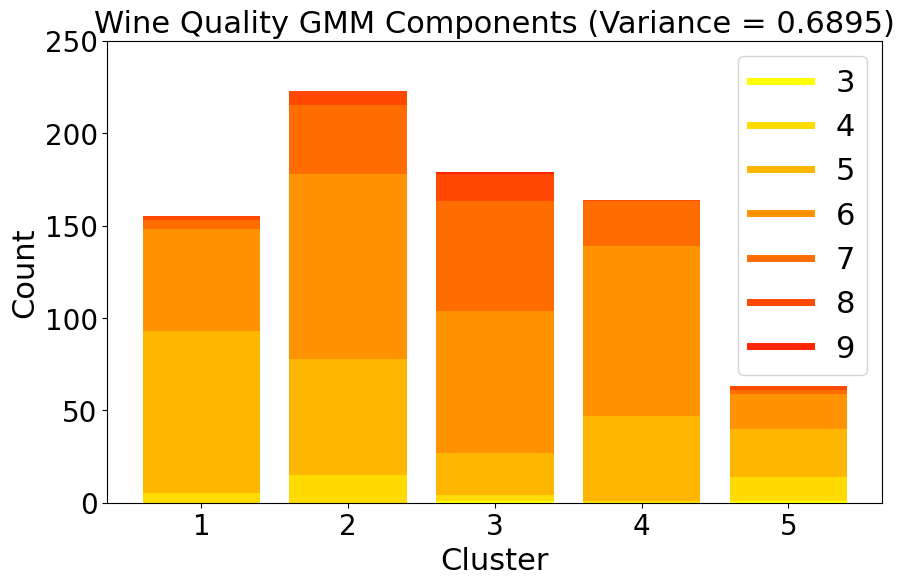

In [14]:
plt.figure(figsize=(10, 6))
for bucket_num, labels in buckets.items():
    bottom = 0
    for label_num in sorted(np.unique(labels)):
        l = sum(labels == label_num)
        plt.bar(bucket_num+1, l, bottom=bottom, color=COLORS[label_num])
        bottom += l

# get variance
weighted_var = 0
for bucket_num, labels in buckets.items():
    if len(labels) == 0:
        continue
    weighted_var += np.var(labels) * len(labels)
weighted_var /= len(y_test)

fontsize = 22
plt.title(f'{DATASET_STR} GMM Components (Variance = {weighted_var:.4f})', fontsize=fontsize)
plt.xlabel('Cluster', fontsize=fontsize)
plt.ylabel('Count', fontsize=fontsize)

# set fontsize for ticks
plt.xticks(fontsize=fontsize-2)
plt.yticks(fontsize=fontsize-2)

custom_lines = [plt.Line2D([0], [0], color=COLORS[i], lw=5) for i in LABELS]
plt.legend(custom_lines, LABELS, fontsize=fontsize)

plt.ylim(0, 250)

path = '/Users/sdale/repos/gatech/machine_learning/unsupervised_learning/final_results/step_1/wine_quality_gmm_bars.png'
os.makedirs(os.path.dirname(path), exist_ok=True)
plt.savefig(path)